In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sys
sys.path.append("../utils")
sys.path.append("../data/")
from dataconfig import *
from utils import *
import numpy as np 

{'SPARSE_FEATURES': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'], 'DENSE_FEATURES': ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13'], 'label': ['label']}


In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
def get_xy_fd():
    # Notice: History behavior sequence feature name must start with "hist_".
    behavior_feature_list = ["item_id", "cate_id"]
    uid = np.array([0, 1, 2])
    click_cnts = np.array([10, 200, 5])
    pay_price = np.array([1000, 2000, 0])
    ugender = np.array([0, 1, 0])
    iid = np.array([1, 2, 3])  # 0 is mask value
    cate_id = np.array([1, 2, 2])  # 0 is mask value
    pay_score = np.array([0.1, 0.2, 0.3])

    hist_iid = np.array([[1, 2, 3, 0], [3, 2, 1, 0], [1, 2, 0, 0]])
    hist_cate_id = np.array([[1, 2, 2, 0], [2, 2, 1, 0], [1, 2, 0, 0]])
    seq_length = np.array([3, 3, 2])  # the actual length of the behavior sequence

    feature_dict = {'user'          : uid, 
                    'gender'        : ugender,
                    'item_id'       : iid, 
                    'cate_id'       : cate_id,
                    'hist_item_id'  : hist_iid, 
                    'hist_cate_id'  : hist_cate_id,
                    'pay_score'     : pay_score,
                    'seq_length'    : seq_length,
                    'click_cnts'    :click_cnts,
                    'pay_price'     : pay_price
                   }
    x = feature_dict
    y = np.array([1, 0, 1])
    return x, y, behavior_feature_list

In [4]:
x, y, behavior_list = get_xy_fd()

In [5]:
numeric_feature = ['click_cnts', 'pay_price']
behavior_list_feature = ['hist_item_id', 'hist_cate_id']


In [6]:
inputs = { name : keras.Input(name = name, shape = (1,), dtype =  tf.float32 ) for name, v in x.items() if name in numeric_feature}

In [7]:
inputs.update(
    # 看看能不能改成 变长的！！！
    {name: keras.Input(name = name, shape = (len(v[0]), ), dtype = tf.int64) for name, v in x.items() if name in behavior_list_feature }
)

inputs.update(
    {name: keras.Input(name = name, shape = (1, ), dtype = tf.int64) for name, v in x.items() if name not in numeric_feature + behavior_list_feature }
)

In [8]:
from tensorflow.keras import Model
class Input_Process_Model(Model):
    def __init__(self, inputs, behavior_list, log2_features, log10_features, sparse_features):
        super().__init__()
        numeric_features = [] 
        all_features = []
        for name, input in inputs.items():
            if name in log2_features:
                # x = tf.experimental.numpy.log2(input)
                x = tf.math.log1p(input) / tf.math.log(tf.constant(2.0, dtype=tf.float32))
                numeric_features.append(x) 
            elif name in log10_features:
                # x = tf.experimental.numpy.log10(input)
                x = tf.math.log1p(input) / tf.math.log(tf.constant(10.0, dtype=tf.float32))
                numeric_features.append(x)
            
        temp_process = layers.Concatenate()(numeric_features)

        all_features.append(temp_process)
        for name, input in inputs.items():
            if name in sparse_features:
                num_bins = 1000
                look_up = layers.Hashing(num_bins = num_bins)

                embedding = layers.Embedding(num_bins, 8, mask_zero = True)

                #
                if input.dtype != tf.int64:
                    x = look_up(input)
                else:
                    x = input

                
                if name in behavior_list:
                    x = tf.reduce_sum(embedding(x), axis = 1)
                else:
                    x = embedding(x)
                    x = tf.squeeze(x, axis = 1)
                
                all_features.append(x)

        feature_res =  layers.Concatenate()(all_features)

        self.model = keras.Model(inputs, feature_res)
    def call(self, X):
        return self.model(X)


In [9]:
process_model = Input_Process_Model(inputs, ['hist_item_id','hist_cate_id',], ['click_cnts'], ['pay_price'], ['user',        
'gender'      ,
'item_id'     ,
'cate_id'     ,
'hist_item_id',
'hist_cate_id',
'pay_score'   ,
'seq_length'  
]
 )

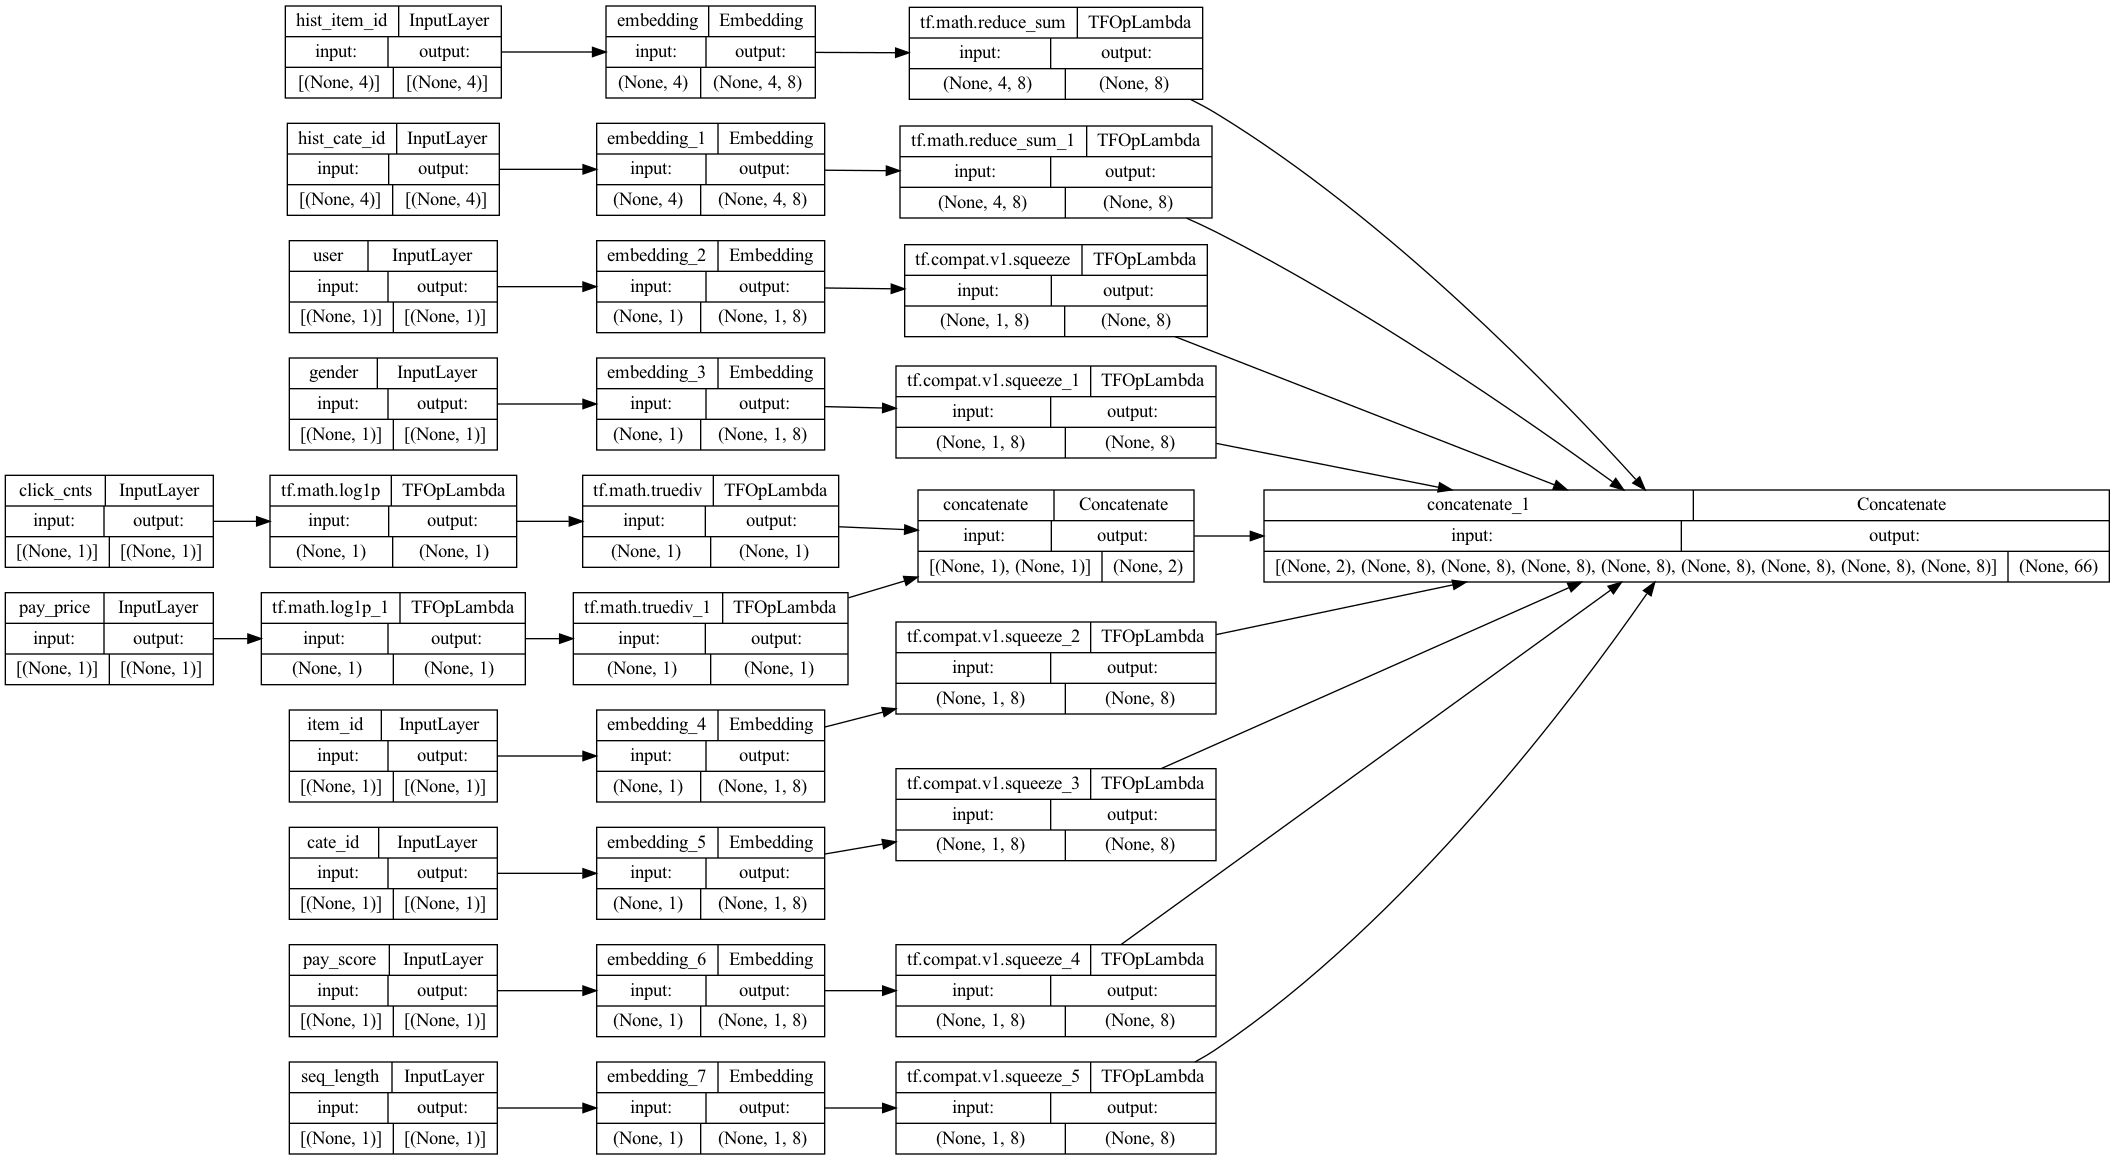

In [10]:
keras.utils.plot_model(process_model.model, show_shapes=True, rankdir = 'LR')

In [19]:
class deepModel(Model):
    def __init__(self, process_model, units = [256, 128, 64]):
        super().__init__()
        self.processmodel = process_model
        self.deep = tf.keras.Sequential([layers.Dense(unit, activation='relu') for unit in units])
        self.deep.add(layers.Dense(1))

    def call(self, inputs):
        x = self.deep(self.processmodel(inputs))
        return tf.sigmoid(x)

    def train_step(self, data):
        inputs, label = data 
        with  tf.GradientTape() as tape:
            y_pred = self(inputs)
            loss = tf.reduce_mean(self.loss(label, y_pred))

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.compiled_metrics.update_state(label, y_pred)
        results = {m.name : m.result() for m in self.metrics}
        return results

In [20]:
model = deepModel(process_model)
model.compile(loss=keras.losses.BinaryFocalCrossentropy(), optimizer='adam', metrics=[tf.metrics.AUC(name = 'auc')])

In [21]:
data = {
    'user': tf.constant([0, 1, 2], dtype=tf.float32),
    'gender': tf.constant([0, 1, 0], dtype=tf.float32),
    'item_id': tf.constant([1, 2, 3], dtype=tf.float32),
    'cate_id': tf.constant([1, 2, 2], dtype=tf.float32),
    'hist_item_id': tf.constant([[1, 2, 3, 0], [3, 2, 1, 0], [1, 2, 0, 0]], dtype=tf.float32),
    'hist_cate_id': tf.constant([[1, 2, 2, 0], [2, 2, 1, 0], [1, 2, 0, 0]], dtype=tf.float32),
    'pay_score': tf.constant([0.1, 0.2, 0.3], dtype=tf.float32),
    'seq_length': tf.constant([3, 3, 2], dtype=tf.float32),
    'click_cnts': tf.constant([10, 200, 5], dtype=tf.float32),
    'pay_price': tf.constant([1000, 2000, 0], dtype=tf.float32),
}
label = tf.reshape(tf.constant([1, 0, 1], dtype=tf.float32), (3, 1))

In [31]:
model.fit(data, label)

1/1 [==============================] - 0s 2ms/step - auc: 1.0000
